In [56]:
%pip install statsmodels

Note: you may need to restart the kernel to use updated packages.


In [57]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import duckdb
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from statsmodels.api import OLS
from scipy.stats import bootstrap
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split


## Poverty

In [58]:
# importing cleaned csv from previous phase
poverty_concat = pd.read_csv('poverty_concat.csv')
poverty_concat.head()

,State,TotalPop,PovertyTotal,PovertyPercent,Year
0,Alabama,4751,796,16.7,2013
1,Alaska,696,76,10.9,2013
2,Arizona,6645,1345,20.2,2013
3,Arkansas,2940,504,17.1,2013
4,California,38050,5675,14.9,2013


## Income 1984-2018

In [59]:
# importing cleaned csv from previous phase
income_df = pd.read_csv('income_df.csv')
income_df.head()

,State,2018,2017,2016,2015,2014,2013,2013.1,2012,2011,...,1993,1992,1991,1990,1989,1988,1987,1986,1985,1984
0,Alabama,49936.0,51113.0,47221.0,44509.0,42278.0,47320.0,41381.0,43464.0,42590.0,...,25082.0,25808.0,24346.0,23357.0,21284.0,19948.0,19734.0,19132.0,18333.0,17310.0
1,Alaska,68734.0,72231.0,75723.0,75112.0,67629.0,72472.0,61137.0,63648.0,57431.0,...,42931.0,41802.0,40612.0,39298.0,36006.0,33103.0,33233.0,31356.0,34782.0,32356.0
2,Arizona,62283.0,61125.0,57100.0,52248.0,49254.0,52611.0,50602.0,47044.0,48621.0,...,30510.0,29358.0,30737.0,29224.0,28552.0,26435.0,26749.0,25500.0,23877.0,21425.0
3,Arkansas,49781.0,48829.0,45907.0,42798.0,44922.0,39376.0,39919.0,39018.0,41302.0,...,23039.0,23882.0,23435.0,22786.0,21433.0,20172.0,18827.0,18730.0,17451.0,15674.0
4,California,70489.0,69759.0,66637.0,63636.0,60487.0,60794.0,57528.0,57020.0,53367.0,...,34073.0,34903.0,33664.0,33290.0,33009.0,30287.0,30146.0,29010.0,26981.0,25287.0


In [60]:
# importing cleaned csv from previous phase
income_melt = pd.read_csv('income_melt_df.csv')
income_melt.head()

,State,Year,Median_Income
0,Alabama,2018,49936.0
1,Alaska,2018,68734.0
2,Arizona,2018,62283.0
3,Arkansas,2018,49781.0
4,California,2018,70489.0


# Unemployment

In [61]:
# importing cleaned csv from previous phase
job_df = pd.read_csv('job_df.csv')
job_melt = pd.read_csv('job_melt.csv')

## Crime 1979-2022

In [62]:
# importing cleaned csv from previous phase
crime_df = pd.read_csv('crime_df.csv')
crime_df

,Year,State_Abbreviation,State,Population,Violent_Crime,Homicide,Rape,Robbery,Aggravated_Assault,Property_Crime,Burglary
0,1979,AK,Alaska,406000,1994,54,292,445,1203,23193,5616
1,1979,AL,Alabama,3769000,15578,496,1037,4127,9918,144372,48517
2,1979,AR,Arkansas,2180000,7984,198,595,1626,5565,70949,21457
3,1979,AZ,Arizona,2450000,14528,219,1120,4305,8884,177977,48916
4,1979,CA,California,22696000,184087,2952,12239,75767,93129,1511021,496310
...,...,...,...,...,...,...,...,...,...,...,...
2239,2022,VA,Virginia,8683619,20624,641,2791,3360,13832,148845,10944
2240,2022,WA,Washington,7785786,29504,400,3208,6766,19130,262437,43987
2241,2022,WV,West Virginia,1775156,5213,95,909,210,3999,23663,3561
2242,2022,WI,Wisconsin,5892539,17889,322,2452,2350,12765,80703,9137


# Hypothesis 1:
### Income is a better predictor for robbery than burglary across the states.

### Train model for predicting robbery using income

In [63]:
income_robbery = duckdb.sql('''SELECT  Robbery,C.State, C.Year, Median_Income
                            FROM crime_df AS C JOIN income_melt AS I
                            ON C.State = I.State AND C.Year = I.Year
                            ORDER BY C.Year ASC''').df()
income_robbery = pd.get_dummies(income_robbery,prefix='', \
                                prefix_sep='', columns=['State'], dtype=int, drop_first=True)
income_robbery.head()

,Robbery,Year,Median_Income,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,...,South Dakota,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming
0,547,1984,32356.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,3833,1984,17310.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1587,1984,15674.0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4003,1984,21425.0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,83924,1984,25287.0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [64]:
X_inc_rob_train, X_inc_rob_test, y_inc_rob_train, y_inc_rob_test = \
                  train_test_split(income_robbery.iloc[:,1:],
                                   income_robbery['Robbery'], test_size=0.3, shuffle=False)
X_inc_rob_train = sm.add_constant(X_inc_rob_train)
inc_rob_model =sm.OLS(y_inc_rob_train, X_inc_rob_train).fit()
inc_rob_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Robbery   R-squared:                       0.896
Model:                            OLS   Adj. R-squared:                  0.891
Method:                 Least Squares   F-statistic:                     203.3
Date:                Thu, 21 Nov 2024   Prob (F-statistic):               0.00
Time:                        19:50:45   Log-Likelihood:                -12665.
No. Observations:                1260   AIC:                         2.543e+04
Df Residuals:                    1208   BIC:                         2.570e+04
Df Model:                          51                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           1.052e+05   1.75e+05      0.601      0.548   -2.38e+05    4.49e+05
Year             -48.2927     88.778     -0.544      0.587    -222.469     125.883
Median_Income     -0.0896      0.073     -1.225      0.221      -0.233       0.054
Alaska         -3938.6943   2025.144     -1.945      0.052   -7911.884      34.495
Arizona         1410.7541   1628.548      0.866      0.387   -1784.343    4605.851
Arkansas       -3766.4762   1600.317     -2.354      0.019   -6906.186    -626.767
California      7.948e+04   1768.805     44.933      0.000     7.6e+04    8.29e+04
Colorado       -1423.9063   1789.294     -0.796      0.426   -4934.375    2086.563
Connecticut      654.6811   1994.790      0.328      0.743   -3258.956    4568.318
Delaware       -3857.7114   1754.645     -2.199      0.028   -7300.202    -415.220
Florida         3.364e+04   1603.309     20.980      0.000    3.05e+04    3.68e+04
Georgia         9127.7609   1632.680      5.591      0.000    5924.557    1.23e+04
Hawaii         -3615.1471   1905.102     -1.898      0.058   -7352.823     122.529
Idaho          -5556.5806   1628.121     -3.413      0.001   -8750.839   -2362.323
Illinois        2.786e+04   1733.039     16.075      0.000    2.45e+04    3.13e+04
Indiana          805.8084   1642.412      0.491      0.624   -2416.489    4028.106
Iowa           -4450.8625   1645.437     -2.705      0.007   -7679.095   -1222.630
Kansas         -3348.4027   1645.677     -2.035      0.042   -6577.106    -119.700
Kentucky       -2774.0674   1605.632     -1.728      0.084   -5924.205     376.071
Louisiana       2780.7335   1605.876      1.732      0.084    -369.882    5931.349
Maine          -5487.7169   1628.862     -3.369      0.001   -8683.429   -2292.005
Maryland        1.102e+04   2004.144      5.501      0.000    7092.002     1.5e+04
Massachusetts   3906.7616   1858.421      2.102      0.036     260.670    7552.854
Michigan        1.278e+04   1708.102      7.481      0.000    9427.985    1.61e+04
Minnesota       -661.6660   1816.302     -0.364      0.716   -4225.123    2901.791
Mississippi    -3573.7185   1622.849     -2.202      0.028   -6757.635    -389.802
Missouri        3117.8066   1643.731      1.897      0.058    -107.077    6342.690
Montana        -5919.7864   1605.562     -3.687      0.000   -9069.786   -2769.787
Nebraska       -4594.0111   1654.689     -2.776      0.006   -7840.394   -1347.629
Nevada          -888.3281   1728.822     -0.514      0.607   -4280.155    2503.499
New Hampshire  -4456.5554   1934.149     -2.304      0.021   -8251.219    -661.892
New Jersey      1.291e+04   2027.969      6.365      0.000    8928.610    1.69e+04
New Mexico     -3927.8848   1605.517     -2.446      0.015   -7077.796    -777.973
New York        6.177e+04   1674.747     36.883      0.000    5.85e+04    6.51e+04
North Caroli

In [65]:
#make predictions
X_inc_rob_test = sm.add_constant(X_inc_rob_test)
inc_rob_preds = inc_rob_model.predict(X_inc_rob_test)
print( f"MAE for predicting robbery using income: {mean_absolute_error(y_inc_rob_test, inc_rob_preds)}")
print( f"RSME for predicting robbery using income: {root_mean_squared_error(y_inc_rob_test, inc_rob_preds)}")

MAE for predicting robbery using income: 3903.3094398751614
RSME for predicting robbery using income: 7759.480589023324


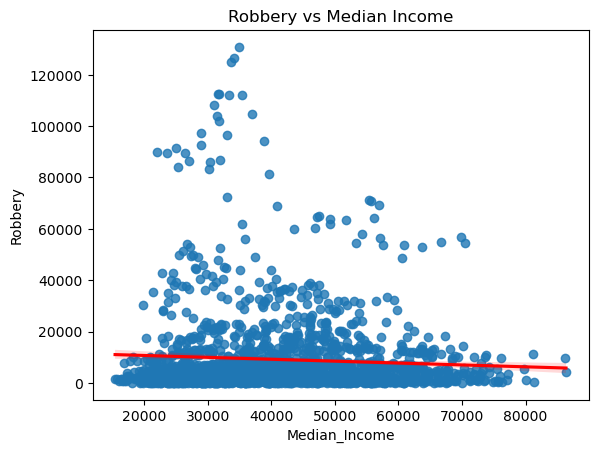

In [66]:
sns.regplot(x = income_robbery['Median_Income'], y = income_robbery['Robbery'], line_kws = {"color":"red"});
plt.title("Robbery vs Median Income");

Since the y value rises exponentionally comparatively to the x value. We want to take a log transform of the robbery (y value). Also, based on where the linear regression line is positioned, we can see that the y values have a lot of outliers that can be dealt with using a log transform on the y axis.

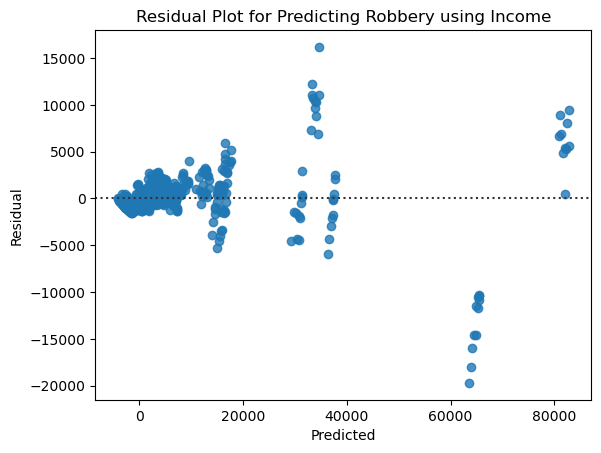

In [67]:
inc_rob_df = pd.DataFrame({"Preds": inc_rob_preds, "Actual": y_inc_rob_test})
ax = sns.residplot(x = inc_rob_preds, y = y_inc_rob_test)
ax.set(xlabel = "Predicted", ylabel= "Residual", title = "Residual Plot for Predicting Robbery using Income");

We also see in the residual plot of the predicted robbery vs the actual predicted robbery that it is relatively hereteroskedastic, further evidencing our need for a log transform.

MAE for predicting robbery using income: 0.2995251380922235
RSME for predicting robbery using income: 0.3845879612087546


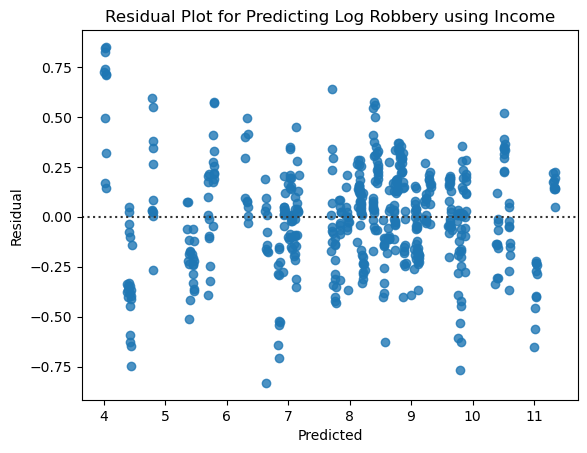

In [68]:
income_robbery['log_robbery'] = np.log(income_robbery['Robbery'])

#print(income_robbery.iloc[:, 47:])
#print((income_robbery.iloc[:, 1:-1]).columns)

X_inc_rob_train, X_inc_rob_test, y_inc_rob_train, y_inc_rob_test = \
                  train_test_split(income_robbery.iloc[:,1:-1],
                                   income_robbery['log_robbery'], test_size=0.3, shuffle=False)
X_inc_rob_train = sm.add_constant(X_inc_rob_train)
inc_rob_model =sm.OLS(y_inc_rob_train, X_inc_rob_train).fit()

X_inc_rob_test = sm.add_constant(X_inc_rob_test)
inc_rob_preds = inc_rob_model.predict(X_inc_rob_test)
print( f"MAE for predicting robbery using income: {mean_absolute_error(y_inc_rob_test, inc_rob_preds)}")
print( f"RSME for predicting robbery using income: {root_mean_squared_error(y_inc_rob_test, inc_rob_preds)}")


inc_rob_df = pd.DataFrame({"Preds": inc_rob_preds, "Actual": y_inc_rob_test})
ax = sns.residplot(x = inc_rob_preds, y = y_inc_rob_test)
ax.set(xlabel = "Predicted", ylabel= "Residual", title = "Residual Plot for Predicting Log Robbery using Income");

After taking the log of robbery (y) we can see that the residual plot is much more random, rather than the fan shape (heteroskedastivity) that was represented in the previous graph. Moreover, the MAE and RMSE decreased exponentionally, showing that our model has become much more accurate, after we took the log or robbery. 

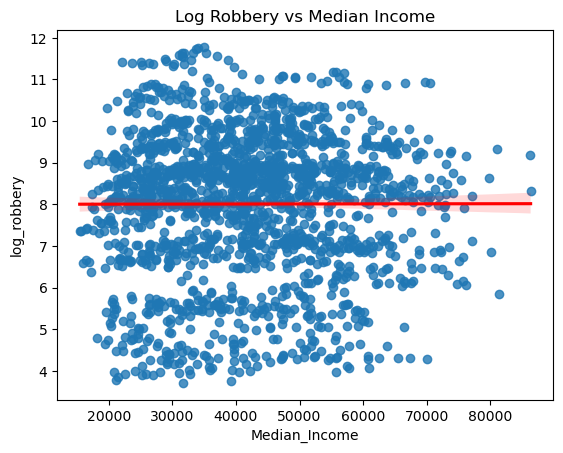

In [69]:
sns.regplot(x = income_robbery['Median_Income'], y = income_robbery['log_robbery'], line_kws = {"color":"red"});
plt.title("Log Robbery vs Median Income");

In [70]:
# for each of the states, get the predicted value and the actual value
X_inc_rob_test2 = X_inc_rob_test
X_inc_rob_test2['actual_robbery'] = y_inc_rob_test
X_inc_rob_test2['preds_robbery'] = inc_rob_preds
inc_rob_melt = pd.melt(X_inc_rob_test2, id_vars=['const','Year', 'Median_Income', 'actual_robbery','preds_robbery'], \
                       var_name = 'State', value_name='Binary')
inc_rob_melt = inc_rob_melt[ inc_rob_melt['Binary']==1]
inc_rob_melt.head()

,const,Year,Median_Income,actual_robbery,preds_robbery,State,Binary
40,1.0,2010,57848.0,6.386879,6.347382,Alaska,1
90,1.0,2011,57431.0,6.356108,6.355366,Alaska,1
140,1.0,2012,63648.0,6.445720,6.334015,Alaska,1
190,1.0,2013,61137.0,6.434547,6.351259,Alaska,1
229,1.0,2013,72472.0,6.434547,6.301135,Alaska,1


In [71]:
twenty_states = pd.DataFrame(np.random.choice(inc_rob_melt['State'], size =20, replace = False))
#print(twenty_states)
chosen_stats_robbery = duckdb.sql(''' SELECT * FROM inc_rob_melt
                                  WHERE Year>=2014 AND Year<=2018 AND State IN (SELECT * FROM twenty_states)''').df()
chosen_stats_robbery.head()

,const,Year,Median_Income,actual_robbery,preds_robbery,State,Binary
0,1.0,2014,44922.0,7.619233,7.836800,Arkansas,1
1,1.0,2015,42798.0,7.657755,7.852333,Arkansas,1
2,1.0,2016,45907.0,7.661527,7.844725,Arkansas,1
3,1.0,2017,48829.0,7.599902,7.837944,Arkansas,1
4,1.0,2018,49781.0,7.373374,7.839875,Arkansas,1


# Income and Robbery for 2016

In [72]:
robbery_2016= chosen_stats_robbery[chosen_stats_robbery['Year']==2016]
robbery_2016_actual = robbery_2016.drop(columns=['const','Binary','preds_robbery'])
robbery_2016_actual['Type'] = 'Actual'
robbery_2016_actual = robbery_2016_actual.rename(columns = {'actual_robbery':'robbery'})

robbery_2016_preds = robbery_2016.loc[:,['Year','Median_Income', 'preds_robbery','State']]
robbery_2016_preds = robbery_2016_preds.rename(columns = {'preds_robbery':'robbery'})
robbery_2016_preds['Type'] = 'Predicted'
print(robbery_2016_actual.head())
robbery_2016_preds.head()

    Year  Median_Income    robbery        State    Type
2   2016        45907.0   7.661527     Arkansas  Actual
7   2016        66637.0  10.911245   California  Actual
12  2016        75923.0   7.905073  Connecticut  Actual
17  2016        53527.0   9.402117      Georgia  Actual
22  2016        56564.0   5.361292        Idaho  Actual


,Year,Median_Income,robbery,State,Type
2,2016,45907.0,7.844725,Arkansas,Predicted
7,2016,66637.0,11.319757,California,Predicted
12,2016,75923.0,8.545309,Connecticut,Predicted
17,2016,53527.0,9.622485,Georgia,Predicted
22,2016,56564.0,5.454049,Idaho,Predicted


In [73]:
robbery_2016_preds_actual = pd.concat([robbery_2016_actual , robbery_2016_preds], ignore_index=True, axis=0)
#robbery_2016_preds_actual

[Text(0.5, 1.0, 'Income and Robbery for 20 Random States (2016)')]

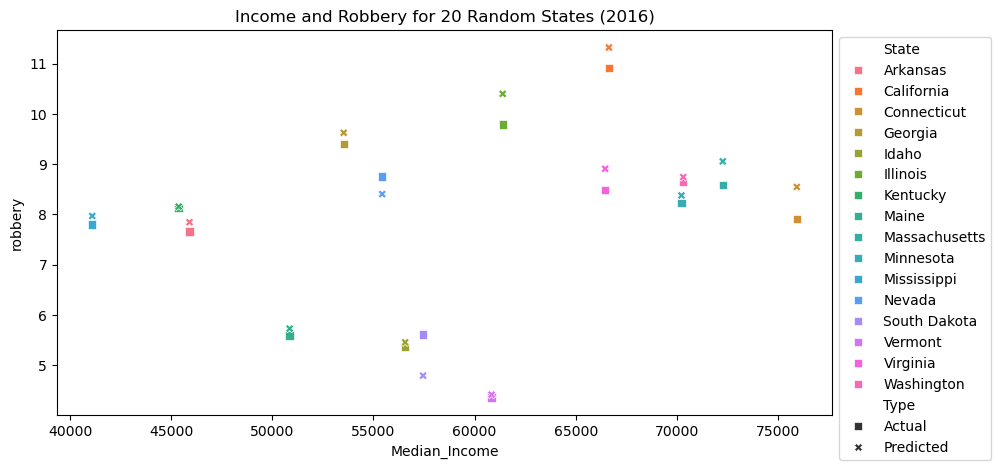

In [74]:
markers = {"Predicted":'X', 'Actual':'s'}
g = sns.scatterplot(data = robbery_2016_preds_actual, x='Median_Income',y='robbery',\
                hue='State', style = 'Type', markers = markers)
g.figure.set_size_inches(10,5)
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
g.set(title = "Income and Robbery for 20 Random States (2016)")

# Income and Robbery for 2017

In [75]:
robbery_2017= chosen_stats_robbery[chosen_stats_robbery['Year']==2017]
robbery_2017_actual = robbery_2017.drop(columns=['const','Binary','preds_robbery'])
robbery_2017_actual['Type'] = 'Actual'
robbery_2017_actual = robbery_2017_actual.rename(columns = {'actual_robbery':'robbery'})

robbery_2017_preds = robbery_2017.loc[:,['Year','Median_Income', 'preds_robbery','State']]
robbery_2017_preds = robbery_2017_preds.rename(columns = {'preds_robbery':'robbery'})
robbery_2017_preds['Type'] = 'Predicted'
robbery_2017_preds_actual = pd.concat([robbery_2017_actual , robbery_2017_preds], ignore_index=True, axis=0)
#print(robbery_2017_actual.head())
#robbery_2017_preds.head()

[Text(0.5, 1.0, 'Income and Robbery for 20 Random States (2017)')]

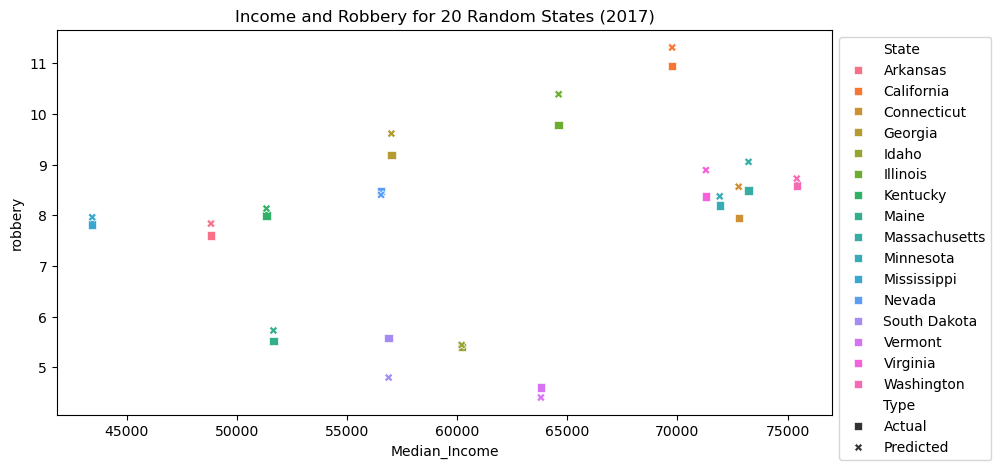

In [76]:
markers = {"Predicted":'X', 'Actual':'s'}
g = sns.scatterplot(data = robbery_2017_preds_actual, x='Median_Income',y='robbery',\
                hue='State', style = 'Type', markers = markers)
g.figure.set_size_inches(10,5)
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
g.set(title = "Income and Robbery for 20 Random States (2017)")

# Income and Robbery for 2018

In [77]:
robbery_2018= chosen_stats_robbery[chosen_stats_robbery['Year']==2018]
robbery_2018_actual = robbery_2018.drop(columns=['const','Binary','preds_robbery'])
robbery_2018_actual['Type'] = 'Actual'
robbery_2018_actual = robbery_2018_actual.rename(columns = {'actual_robbery':'robbery'})

robbery_2018_preds = robbery_2018.loc[:,['Year','Median_Income', 'preds_robbery','State']]
robbery_2018_preds = robbery_2018_preds.rename(columns = {'preds_robbery':'robbery'})
robbery_2018_preds['Type'] = 'Predicted'
robbery_2018_preds_actual = pd.concat([robbery_2018_actual , robbery_2018_preds], ignore_index=True, axis=0)

[Text(0.5, 1.0, 'Income and Robbery for 20 Random States (2018)')]

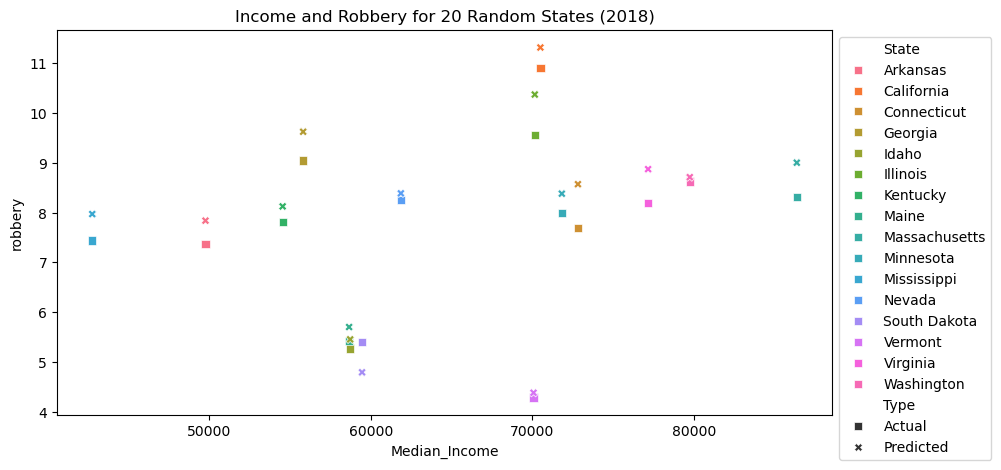

In [78]:
markers = {"Predicted":'X', 'Actual':'s'}
g = sns.scatterplot(data = robbery_2018_preds_actual, x='Median_Income',y='robbery',\
                hue='State', style = 'Type', markers = markers)
g.figure.set_size_inches(10,5)
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
g.set(title = "Income and Robbery for 20 Random States (2018)")

### Now train model for predicting burglary given income

In [79]:
income_burglary = duckdb.sql('''SELECT  Burglary,C.State, C.Year, Median_Income
                            FROM crime_df AS C JOIN income_melt AS I
                            ON C.State = I.State AND C.Year = I.Year
                            ORDER BY C.Year ASC''').df()
income_burglary = pd.get_dummies(income_burglary,prefix='', \
                                prefix_sep='', columns=['State'], dtype=int, drop_first=True)
income_burglary.head()

,Burglary,Year,Median_Income,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,...,South Dakota,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming
0,6184,1984,32356.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,39970,1984,17310.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,20810,1984,15674.0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,52327,1984,21425.0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,443094,1984,25287.0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [80]:
X_inc_burg_train, X_inc_burg_test, y_inc_burg_train, y_inc_burg_test = \
                  train_test_split(income_burglary.iloc[:,1:],
                                   income_burglary['Burglary'], test_size=0.3, shuffle=False)
X_inc_burg_train = sm.add_constant(X_inc_burg_train)
inc_burg_model =sm.OLS(y_inc_burg_train, X_inc_burg_train).fit()
print(inc_burg_model.summary())

                            OLS Regression Results                            
Dep. Variable:               Burglary   R-squared:                       0.926
Model:                            OLS   Adj. R-squared:                  0.923
Method:                 Least Squares   F-statistic:                     298.0
Date:                Thu, 21 Nov 2024   Prob (F-statistic):               0.00
Time:                        19:50:47   Log-Likelihood:                -14133.
No. Observations:                1260   AIC:                         2.837e+04
Df Residuals:                    1208   BIC:                         2.864e+04
Df Model:                          51                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           1.629e+06   5.61e+05      2.

In [81]:
X_inc_burg_test = sm.add_constant(X_inc_burg_test)
inc_burg_preds = inc_burg_model.predict(X_inc_burg_test)
print( f"MAE for predicting burglary using income: {mean_absolute_error(y_inc_burg_test, inc_burg_preds)}")
print( f"RSME for predicting burglary using income: {root_mean_squared_error(y_inc_burg_test, inc_burg_preds)}")

MAE for predicting burglary using income: 17550.1657301236
RSME for predicting burglary using income: 25884.34927546979


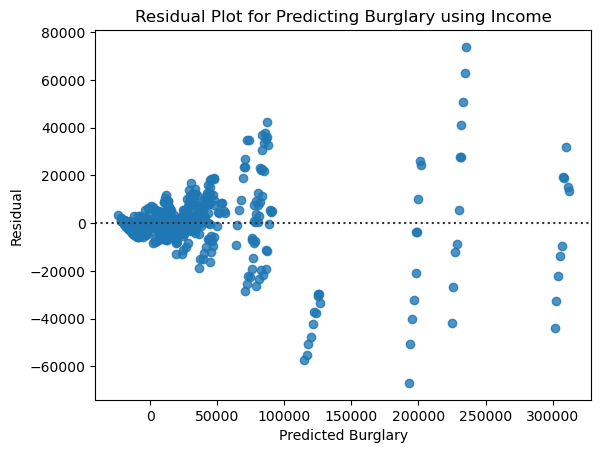

In [82]:
inc_burg_df = pd.DataFrame({"Preds": inc_burg_preds, "Actual": y_inc_burg_test})
ax = sns.residplot(x = inc_burg_preds, y = y_inc_burg_test)
ax.set(xlabel = "Predicted Burglary", ylabel= "Residual", title = "Residual Plot for Predicting Burglary using Income");

The residual plot is extremely heteroskedastic. This shows a need for a log transformation.

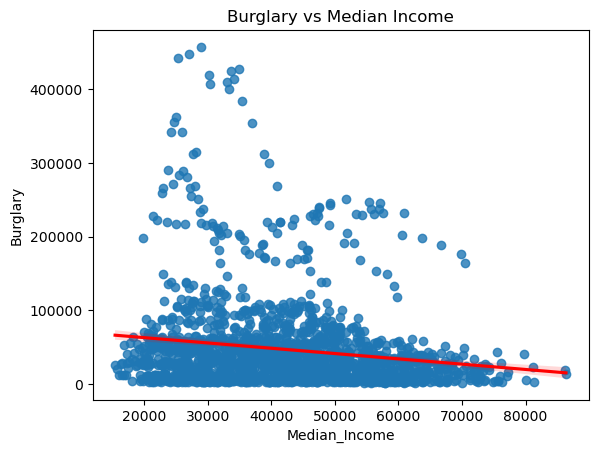

In [83]:
sns.regplot(x = income_burglary['Median_Income'], y = income_burglary['Burglary'], line_kws = {"color":"red"});
plt.title("Burglary vs Median Income");

Based on this linear regression, we can see that there are a lot of outliers, especially vertically (y axis). Thus, it can make sense to utilize a log transform on the y (burglary) to deal with the heteroskedasticity from the residual plot and also "push" the data points in this plot closer to the actual linear regression.

MAE for predicting burglary using income: 0.1894950245621107
RSME for predicting burglary using income: 0.25217229608909597


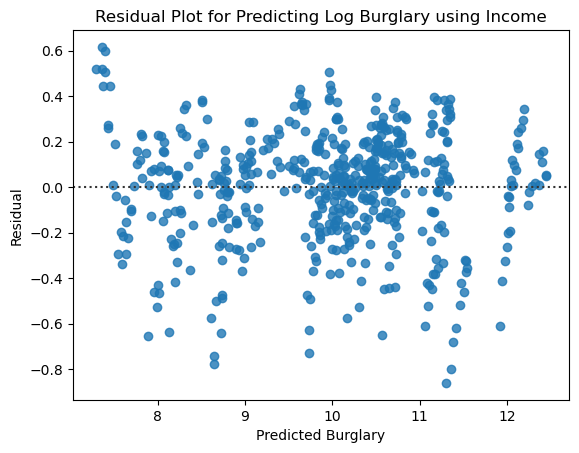

In [84]:
income_burglary['log_burglary'] = np.log(income_burglary['Burglary'])

X_inc_burg_train, X_inc_burg_test, y_inc_burg_train, y_inc_burg_test = \
                  train_test_split(income_burglary.iloc[:,1:-1],
                                   income_burglary['log_burglary'], test_size=0.3, shuffle=False)
X_inc_burg_train = sm.add_constant(X_inc_burg_train)
inc_burg_model =sm.OLS(y_inc_burg_train, X_inc_burg_train).fit()

X_inc_burg_test = sm.add_constant(X_inc_burg_test)
inc_burg_preds = inc_burg_model.predict(X_inc_burg_test)
print( f"MAE for predicting burglary using income: {mean_absolute_error(y_inc_burg_test, inc_burg_preds)}")
print( f"RSME for predicting burglary using income: {root_mean_squared_error(y_inc_burg_test, inc_burg_preds)}")

inc_burg_df = pd.DataFrame({"Preds": inc_burg_preds, "Actual": y_inc_burg_test})
ax = sns.residplot(x = inc_burg_preds, y = y_inc_burg_test)
ax.set(xlabel = "Predicted Burglary", ylabel= "Residual", title = "Residual Plot for Predicting Log Burglary using Income");

After doing the log transformation on the y axis (burglary), we can see that our residual plot is much more random than before. It no longer exhibits the fan-shaped heteroskedascticity from earlier. Moreover, the MAE and RMSE also decreased drastically from our previous model (before the log transformation), showing that our model has also become much more accurate. 

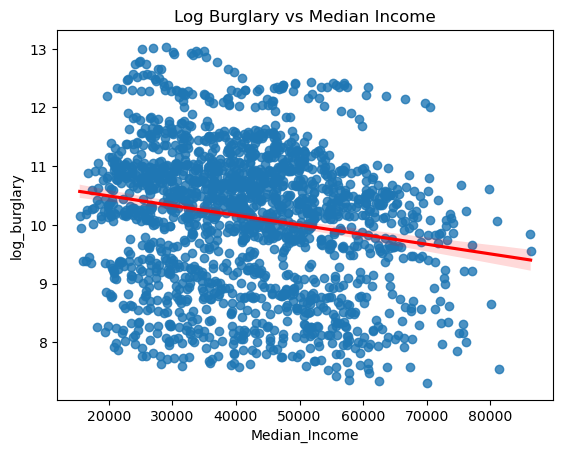

In [85]:
sns.regplot(x = income_burglary['Median_Income'],
            y = income_burglary['log_burglary'],
            line_kws = {"color":"red"})
plt.title("Log Burglary vs Median Income");

# Now plot predicted vs actual when using income to predict burglary

In [86]:
X_inc_burg_test2 = X_inc_burg_test
X_inc_burg_test2['actual_burglary'] = y_inc_burg_test
X_inc_burg_test2['preds_burglary'] = inc_burg_preds
inc_burg_melt = pd.melt(X_inc_burg_test2, id_vars=['const','Year', 'Median_Income', 'actual_burglary','preds_burglary'], \
                       var_name = 'State', value_name='Binary')
inc_burg_melt = inc_burg_melt[ inc_burg_melt['Binary']==1]
inc_burg_melt.head()

,const,Year,Median_Income,actual_burglary,preds_burglary,State,Binary
40,1.0,2010,57848.0,8.040769,8.225878,Alaska,1
90,1.0,2011,57431.0,7.955776,8.224721,Alaska,1
140,1.0,2012,63648.0,7.989560,8.155338,Alaska,1
190,1.0,2013,61137.0,7.978311,8.175717,Alaska,1
229,1.0,2013,72472.0,7.978311,8.059143,Alaska,1


In [87]:
chosen_stats_burglary = duckdb.sql(''' SELECT * FROM inc_burg_melt
                                  WHERE Year>=2014 AND Year<=2018 AND State IN (SELECT * FROM twenty_states)''').df()
chosen_stats_burglary.head()

,const,Year,Median_Income,actual_burglary,preds_burglary,State,Binary
0,1.0,2014,44922.0,10.119244,9.903828,Arkansas,1
1,1.0,2015,42798.0,10.036750,9.920227,Arkansas,1
2,1.0,2016,45907.0,10.078029,9.882807,Arkansas,1
3,1.0,2017,48829.0,10.015431,9.847311,Arkansas,1
4,1.0,2018,49781.0,9.879195,9.832075,Arkansas,1


# Income and Burglary for 2016

In [88]:
burglary_2016= chosen_stats_burglary[chosen_stats_burglary['Year']==2016]
burglary_2016_actual = burglary_2016.drop(columns=['const','Binary','preds_burglary'])
burglary_2016_actual['Type'] = 'Actual'
burglary_2016_actual = burglary_2016_actual.rename(columns = {'actual_burglary':'burglary'})

burglary_2016_preds = burglary_2016.loc[:,['Year','Median_Income', 'preds_burglary','State']]
burglary_2016_preds = burglary_2016_preds.rename(columns = {'preds_burglary':'burglary'})
burglary_2016_preds['Type'] = 'Predicted'
burglary_2016_preds_actual = pd.concat([burglary_2016_actual , burglary_2016_preds], ignore_index=True, axis=0)
#burglary_2016_preds_actual

[Text(0.5, 1.0, 'Income and Burglary for 20 Random States (2016)')]

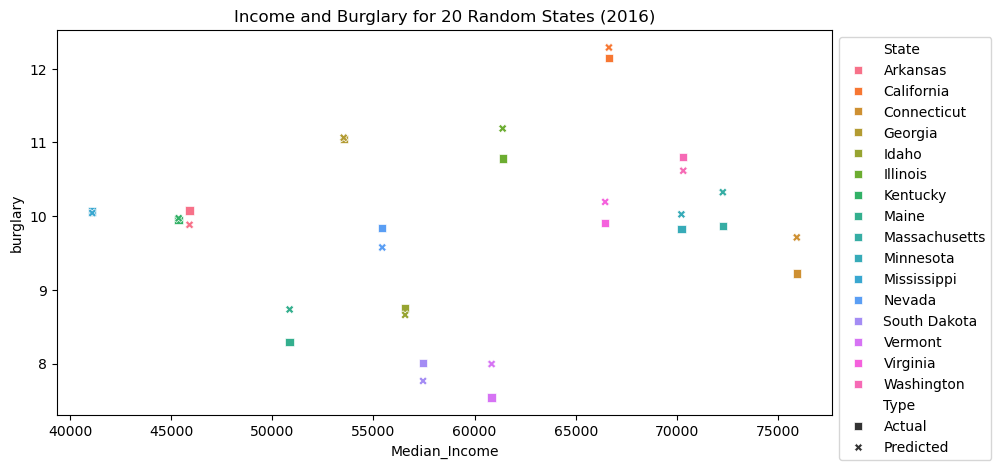

In [89]:
g = sns.scatterplot(data = burglary_2016_preds_actual, x='Median_Income',y='burglary',\
                hue='State', style = 'Type', markers = markers)
g.figure.set_size_inches(10,5)
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
g.set(title = "Income and Burglary for 20 Random States (2016)")

# Income and Burglary for 2017

In [90]:
burglary_2017= chosen_stats_burglary[chosen_stats_burglary['Year']==2017]
burglary_2017_actual = burglary_2017.drop(columns=['const','Binary','preds_burglary'])
burglary_2017_actual['Type'] = 'Actual'
burglary_2017_actual = burglary_2017_actual.rename(columns = {'actual_burglary':'burglary'})

burglary_2017_preds = burglary_2017.loc[:,['Year','Median_Income', 'preds_burglary','State']]
burglary_2017_preds = burglary_2017_preds.rename(columns = {'preds_burglary':'burglary'})
burglary_2017_preds['Type'] = 'Predicted'
burglary_2017_preds_actual = pd.concat([burglary_2017_actual , burglary_2017_preds], ignore_index=True, axis=0)
#burglary_2017_preds_actual

[Text(0.5, 1.0, 'Income and Burglary for 20 Random States (2017)')]

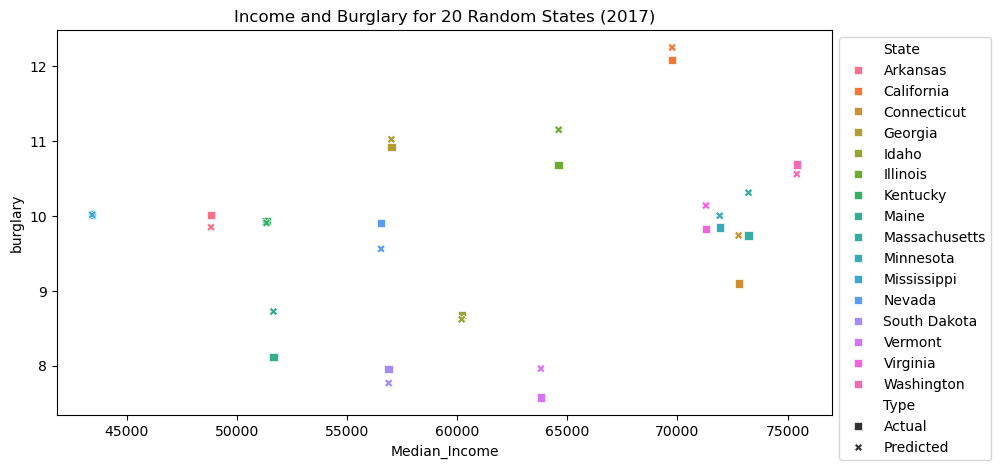

In [91]:
g = sns.scatterplot(data = burglary_2017_preds_actual, x='Median_Income',y='burglary',\
                hue='State', style = 'Type', markers = markers)
g.figure.set_size_inches(10,5)
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
g.set(title = "Income and Burglary for 20 Random States (2017)")

# Income and Burglary for 2018

In [92]:
burglary_2018= chosen_stats_burglary[chosen_stats_burglary['Year']==2018]
burglary_2018_actual = burglary_2018.drop(columns=['const','Binary','preds_burglary'])
burglary_2018_actual['Type'] = 'Actual'
burglary_2018_actual = burglary_2018_actual.rename(columns = {'actual_burglary':'burglary'})

burglary_2018_preds = burglary_2018.loc[:,['Year','Median_Income', 'preds_burglary','State']]
burglary_2018_preds = burglary_2018_preds.rename(columns = {'preds_burglary':'burglary'})
burglary_2018_preds['Type'] = 'Predicted'
burglary_2018_preds_actual = pd.concat([burglary_2018_actual , burglary_2018_preds], ignore_index=True, axis=0)
#burglary_2018_preds_actual

[Text(0.5, 1.0, 'Income and Burglary for 20 Random States (2018)')]

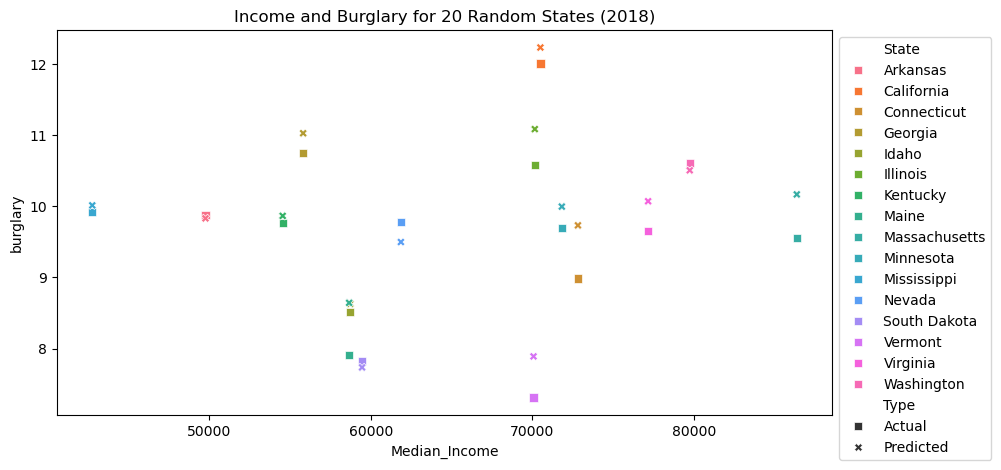

In [93]:
g = sns.scatterplot(data = burglary_2018_preds_actual, x='Median_Income',y='burglary',\
                hue='State', style = 'Type', markers = markers)
g.figure.set_size_inches(10,5)
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
g.set(title = "Income and Burglary for 20 Random States (2018)")

# Hypothesis 2

### There is a relationship among states that are above the U.S. unemployment average over the years 1980 to 2018 in predicting violent crime rates, and there is a relationship among states that are below the U.S. unemploymnent average over the years 1980 to 2018 in predicting violent crime rates.

In [94]:
#avg unemployment in the US
us_avg = job_df.iloc[0, 1:]
#print(us_avg)
us_average = us_avg.sum()/us_avg.size
print(us_average)

6.264102564102564


Looking across all the years from 1980 to 2018, the U.S. unemployment rate average is about 6.264.

In [95]:
#created a dictionary with all states and their respective unemployment averages across the years 1980 to 2018
dict_avg = {}
states = job_df.iloc[1:, 0].reset_index(drop=True) #rows 0,1,...50
#print(states)

#for x in range(1, 38):
for x in range(0,states.size):
    the_avg = job_df.iloc[x+1, 1:] #get the row for this state
    dict_avg[states[x]] = the_avg.sum()/(2018-1980) + 1

print(dict_avg)


{'Alabama': 8.339473684210525, 'Alaska': 8.976315789473684, 'Arizona': 7.371052631578947, 'Arkansas': 7.628947368421051, 'California': 8.39736842105263, 'Colorado': 6.46578947368421, 'Connecticut': 6.518421052631578, 'Delaware': 6.278947368421052, 'District of Columbia': 8.736842105263161, 'Florida': 7.197368421052631, 'Georgia': 7.1236842105263145, 'Hawaii': 5.7026315789473685, 'Idaho': 7.094736842105262, 'Illinois': 8.157894736842106, 'Indiana': 7.342105263157896, 'Iowa': 5.755263157894736, 'Kansas': 5.88157894736842, 'Kentucky': 8.06578947368421, 'Louisiana': 8.507894736842106, 'Maine': 6.776315789473684, 'Maryland': 6.360526315789474, 'Massachusetts': 6.457894736842107, 'Michigan': 9.092105263157896, 'Minnesota': 5.978947368421053, 'Mississippi': 8.807894736842107, 'Missouri': 7.123684210526315, 'Montana': 6.8921052631578945, 'Nebraska': 4.6421052631578945, 'Nevada': 7.75, 'New Hampshire': 5.3578947368421055, 'New Jersey': 7.221052631578949, 'New Mexico': 7.849999999999999, 'New Yo

In [96]:
states_unemp_avg_df = pd.DataFrame({'State':np.asarray(states), 'Avg_Unemployment':dict_avg.values()})
avg_violent_crime_states = duckdb.sql('''SELECT SUM(Violent_Crime)/Count(*) AS AvgViolentCrime, State
                                      FROM crime_df AS C
                                      GROUP BY State''').df()
states_unemp_avg_df = duckdb.sql(''' SELECT A.*, Avg_Unemployment
                                 FROM avg_violent_crime_states  AS A JOIN states_unemp_avg_df AS S
                                  ON A.State  = S.State''').df()
states_unemp_avg_df.head()

,AvgViolentCrime,State,Avg_Unemployment
0,26380.255814,Arizona,7.371053
1,7954.674419,Iowa,5.755263
2,10646.139535,Kansas,5.881579
3,31070.186047,Louisiana,8.507895
4,42952.465116,Ohio,7.902632


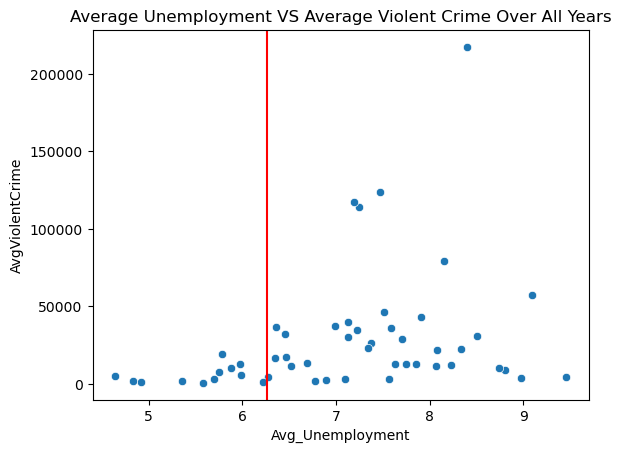

In [97]:
g= sns.scatterplot(data = states_unemp_avg_df, x ='Avg_Unemployment', y='AvgViolentCrime');
plt.axvline(x = us_average, color = "red");
plt.title('Average Unemployment VS Average Violent Crime Over All Years');

This scatterplot is a data visualization that demonstrates the national average unemployment rate as a vertical line. Then, it also represents the 50 states that are scattered across, showing that there are significantly more states that have unemployment rates greater than the national average, comparatively to the number of states below the national average.

Particularly, we plotted this average unemployment rate against the average violent crime (y axis). The general trend that this plot exemplifies is that a greater average unemployment rate corresponds to a greater average violent crime rate. We seek to investigate this through a comparison of two different models, one for states that are below the national unemployment rate average and one for states that are above the national unemployment rate average.

However, first, we want to explore if overall, on average, there is a significant relationship between average unemployment across the years and average violent crime rates over the years.

In [98]:
# generally using OLS regressions to test for significance of relationship between average unemployment rate and average violent crime rates

x_val = states_unemp_avg_df['Avg_Unemployment']
x_val = sm.add_constant(x_val)
y_val = states_unemp_avg_df['AvgViolentCrime']

model = sm.OLS(y_val, x_val)
fitted = model.fit()

print(fitted.summary())

                            OLS Regression Results                            
Dep. Variable:        AvgViolentCrime   R-squared:                       0.087
Model:                            OLS   Adj. R-squared:                  0.068
Method:                 Least Squares   F-statistic:                     4.644
Date:                Thu, 21 Nov 2024   Prob (F-statistic):             0.0361
Time:                        19:50:49   Log-Likelihood:                -609.32
No. Observations:                  51   AIC:                             1223.
Df Residuals:                      49   BIC:                             1227.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const            -4.353e+04   3.37e+04  

Based on this OLS regression, we can observe that the p value for average unemployment rate is less than our signifiance level of 0.05. This is important since it shows that our coefficient is signifiant. Particularly, it has a very coefficient of 1.01e+04, showing a positive relationship between average unemployment rate and average violent crime rates.

In [99]:
# put all states that are lower than the national average in one list
# put all states that are above the national average in another list

less_dict = []
more_dict = []
count = 2
dict_avg[states[count]]

for x in dict_avg:
    rate = dict_avg[x]
    if rate < us_average:
        less_dict.append(x)
    else:
        more_dict.append(x)

print(less_dict)
print(more_dict)


['Hawaii', 'Iowa', 'Kansas', 'Minnesota', 'Nebraska', 'New Hampshire', 'North Dakota', 'South Dakota', 'Utah', 'Vermont', 'Virginia', 'Wyoming']
['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut', 'Delaware', 'District of Columbia', 'Florida', 'Georgia', 'Idaho', 'Illinois', 'Indiana', 'Kentucky', 'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Mississippi', 'Missouri', 'Montana', 'Nevada', 'New Jersey', 'New Mexico', 'New York', 'North Carolina', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina', 'Tennessee', 'Texas', 'Washington', 'West Virginia', 'Wisconsin']


In [100]:
#now get the info for states that have above average
states_above_df = job_melt[ job_melt['Area'].isin(more_dict)]
states_above_df.head()

,Area,Year,UnemploymentRate
1,Alabama,1980,8.9
2,Alaska,1980,9.6
3,Arizona,1980,6.6
4,Arkansas,1980,7.6
5,California,1980,6.8


In [101]:
states_above_df = duckdb.sql('''Select  C.Violent_Crime, S.*
                             FROM states_above_df AS S JOIN crime_df AS C
                             ON  S.Year = C.Year AND S.Area = C.State''').df()
states_above_df.head()

,Violent_Crime,Area,Year,UnemploymentRate
0,1919,Alaska,1980,9.6
1,17320,Alabama,1980,8.9
2,7656,Arkansas,1980,7.6
3,210290,California,1980,6.8
4,15215,Colorado,1980,5.8


In [102]:
states_above_df = pd.get_dummies(states_above_df, prefix='', prefix_sep='',\
                                  drop_first=True, dtype=int, columns=['Area'])
states_above_df['Year'] = states_above_df['Year'].astype(int)
states_above_df.head()

,Violent_Crime,Year,UnemploymentRate,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,...,Oklahoma,Oregon,Pennsylvania,Rhode Island,South Carolina,Tennessee,Texas,Washington,West Virginia,Wisconsin
0,1919,1980,9.6,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,17320,1980,8.9,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,7656,1980,7.6,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,210290,1980,6.8,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,15215,1980,5.8,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


## Train the model for years 1980-2018; unemployment rate and violent crime rate for states above average

In [103]:
X_train_above, X_test_above, Y_train_above, Y_test_above = \
  train_test_split(states_above_df.iloc[:, 1:],states_above_df['Violent_Crime'],\
                    test_size=.30, shuffle=False)
X_train_above = sm.add_constant(X_train_above)
model_above = sm.OLS( Y_train_above,X_train_above).fit()

In [104]:
X_test_above = sm.add_constant(X_test_above)
preds_above = model_above.predict(X_test_above)
y_above_df = pd.DataFrame(data = {"Preds":preds_above, "Actual":Y_test_above})
y_above_df.head()

,Preds,Actual
1064,7026.161604,7866
1065,-281.314908,5048
1066,123445.548808,94087
1067,-693.544532,3348
1068,83410.052612,53556


In [105]:
print( f"MAE for predicting violent crime rate using states above national average: {mean_absolute_error(preds_above,Y_test_above)}")
print( f"RSME for predicting violent crime rate using states above national average: {root_mean_squared_error(preds_above,Y_test_above)}")

MAE for predicting violent crime rate using states above national average: 7915.812378514861
RSME for predicting violent crime rate using states above national average: 15479.315695712612


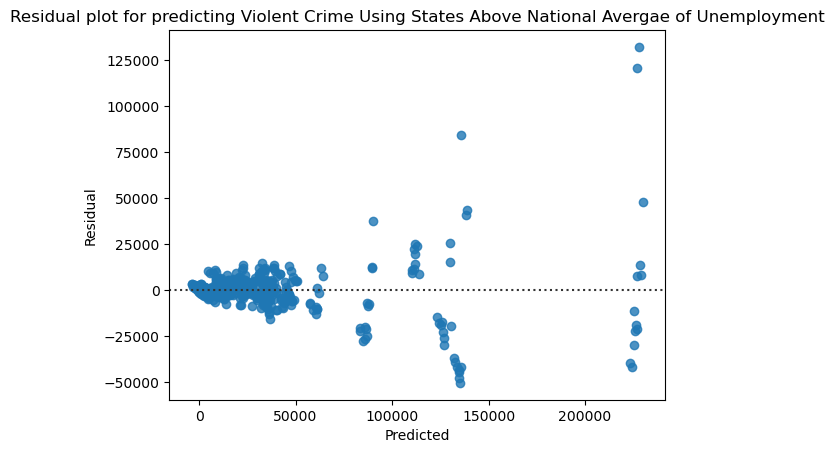

In [106]:
ax = sns.residplot(data= y_above_df, x = 'Preds', y = 'Actual')
ax.set(xlabel = "Predicted", ylabel= "Residual", title="Residual plot for predicting Violent Crime Using States Above National Avergae of Unemployment");

This residual plot is extremely heteroskedastic, fan shaped, which shows a need for a log transformation.

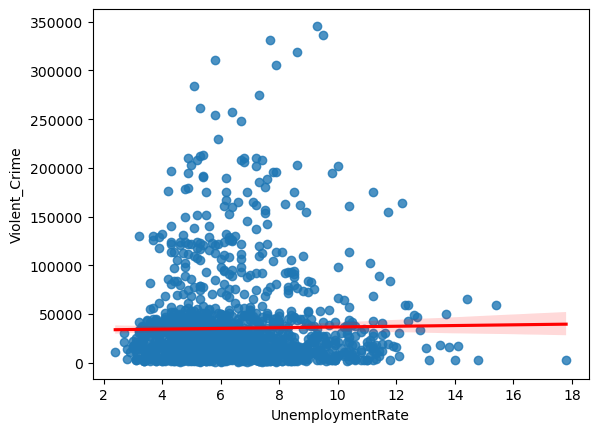

In [107]:
sns.regplot(x = states_above_df['UnemploymentRate'], y = states_above_df['Violent_Crime'], line_kws = {"color":"red"});

Looking at this linear regression plot, we can see a lot of outlier values. More specifically, there are many values that are signficantly above the overall trend of the linear regression line, signifying that we should consider a log transform on the y axis (violent crime rate). Moreover, since there are also seems to be some outliers towards the right of the plot (as most of the data is clustered towards lower x values), we also plan on doing a log transform on the x axis (unemployment rate).

MAE for predicting violent crime rate using states above national average: 0.21877660270929272
RSME for predicting violent crime rate using states above national average: 0.2720943011106594


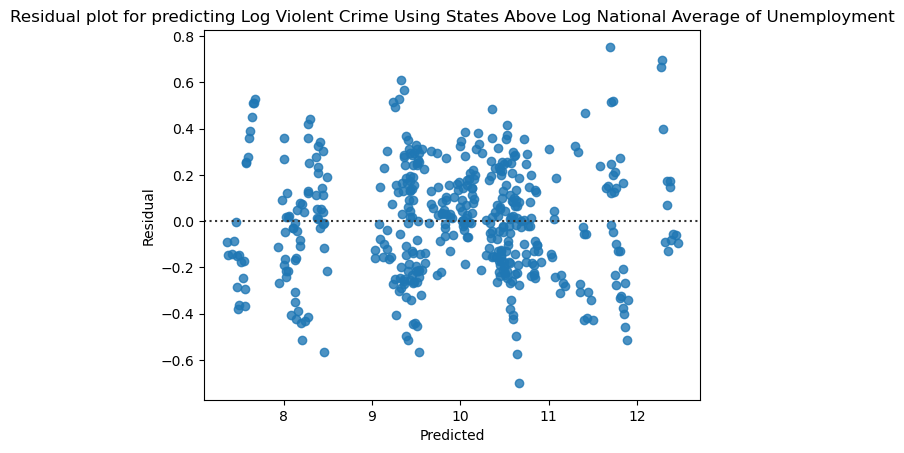

In [108]:
states_above_df['log_unemployment'] = np.log(states_above_df['UnemploymentRate'])
states_above_df['log_crime'] = np.log(states_above_df['Violent_Crime'])
modified_df = states_above_df.drop(columns = "UnemploymentRate")

#print(modifed_df.iloc[:, 1:-1].columns)
X_train_above, X_test_above, Y_train_above, Y_test_above = \
  train_test_split(modified_df.iloc[:, 1:-1],modified_df['log_crime'],\
                    test_size=.30, shuffle=False)
X_train_above = sm.add_constant(X_train_above)
model_above = sm.OLS( Y_train_above,X_train_above).fit()

X_test_above = sm.add_constant(X_test_above)
preds_above = model_above.predict(X_test_above)
y_above_df = pd.DataFrame(data = {"Preds":preds_above, "Actual":Y_test_above})

y_above_df.head()

ax = sns.residplot(data= y_above_df, x = 'Preds', y = 'Actual')
ax.set(xlabel = "Predicted", ylabel= "Residual",
       title="Residual plot for predicting Log Violent Crime Using States Above Log National Average of Unemployment");

print( f"MAE for predicting violent crime rate using states above national average: {mean_absolute_error(preds_above,Y_test_above)}")
print( f"RSME for predicting violent crime rate using states above national average: {root_mean_squared_error(preds_above,Y_test_above)}")

After doing the log transform on both the x and y axes, we have a more random residual plot, which is significantly better than the heteroskedastic plot from earlier. Moreover, after doing these log transforms, we also learned that our MAE and RMSE for predicting violent crime rate using states above the national average are signficantly lower than the previous model. This demonstrates that our log transformations have also made our model more accurate and indicative of what it is trying to measure.

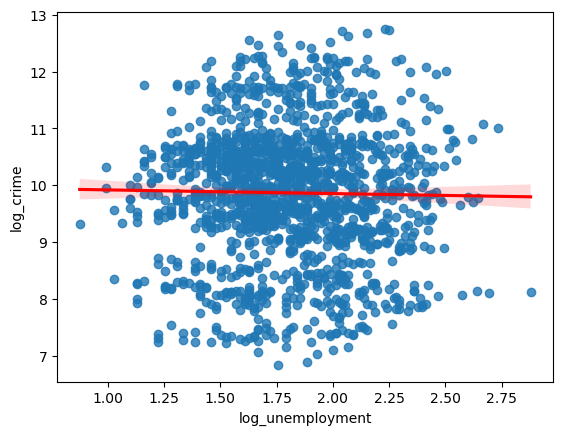

In [109]:
sns.regplot(x = states_above_df['log_unemployment'], y = states_above_df['log_crime'], line_kws = {"color":"red"});

In [110]:
print(model_above.summary())

                            OLS Regression Results                            
Dep. Variable:              log_crime   R-squared:                       0.970
Model:                            OLS   Adj. R-squared:                  0.969
Method:                 Least Squares   F-statistic:                     820.0
Date:                Thu, 21 Nov 2024   Prob (F-statistic):               0.00
Time:                        19:50:51   Log-Likelihood:                 180.36
No. Observations:                1064   AIC:                            -278.7
Df Residuals:                    1023   BIC:                            -74.95
Df Model:                          40                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    5.3260 

In [111]:
print(model_above.params)

const                   5.325987
Year                    0.002511
Alaska                 -1.764312
Arizona                 0.093420
Arkansas               -0.632854
California              2.324917
Colorado               -0.346144
Connecticut            -0.606923
Delaware               -1.661968
District of Columbia   -0.684183
Florida                 1.729079
Georgia                 0.573794
Idaho                  -2.001730
Illinois                1.370516
Indiana                -0.029317
Kentucky               -0.581431
Louisiana               0.390955
Maine                  -2.609738
Maryland                0.517662
Massachusetts           0.420433
Michigan                1.040505
Mississippi            -0.859466
Missouri                0.296987
Montana                -2.486209
Nevada                 -0.712211
New Jersey              0.525756
New Mexico             -0.617922
New York                1.749060
North Carolina          0.493699
Ohio                    0.727094
Oklahoma  

Looking at this OLS regression, we observe that the p value for unemployment rate (what we are interested in) is significant (based on a 0.05 significance level). This shows that we can reject the null hypothesis (that there is no relationship between unemployment rate among states that are above the national average and violent crime rates). There exists a relationship, as exemplified by our p value that is less than the significance level.

Our model takes the form of 

$\ln (\text{crime}) = B_0\cdot \ln(\text{unemploymentRate}) + \beta_1 x_1 + \beta_2x_2 + ...$

$ \exp^{\ln(\text{crime})} =  \exp^{ \beta_0\cdot \ln(\text{unemploymentRate})} \cdot \exp^{\beta_1x_1} \cdot \exp^{\beta_2x_2}\cdot$ 

$\text{crime} = (\text{unemploymentRate})^{\beta_0} \cdot \exp^{\beta_1x_1} \cdot \exp^{\beta_2x_2}\cdot\cdot\cdot$

This means that when the unemployemnt rate changes by a factor of $c$, the amount of violent crime changes by a factor of $c^\beta_0$ where $\beta_0 = -0.178411$ is the coefficient from the model for ln(unemployment)

# Now train model for years 1980-2018; states with unemployment rate below average, violent crime rate

In [112]:
states_below_df = job_melt[ job_melt['Area'].isin(less_dict)]
states_below_df.head()

,Area,Year,UnemploymentRate
12,Hawaii,1980,5.0
16,Iowa,1980,6.0
17,Kansas,1980,4.4
24,Minnesota,1980,5.8
28,Nebraska,1980,3.9


In [113]:
states_below_df = duckdb.sql('''Select  C.Violent_Crime, S.*
                             FROM states_below_df AS S JOIN crime_df AS C
                             ON  S.Year = C.Year AND S.Area = C.State''').df()
states_below_df.head()

,Violent_Crime,Area,Year,UnemploymentRate
0,9168,Kansas,1980,4.4
1,352,North Dakota,1980,4.9
2,3512,Nebraska,1980,3.9
3,4425,Utah,1980,6.2
4,16355,Virginia,1980,5.2


In [114]:
states_below_df = pd.get_dummies(states_below_df, prefix='', prefix_sep='',\
                                  drop_first=True, dtype=int, columns=['Area'])
states_below_df['Year'] = states_below_df['Year'].astype(int)
states_below_df.head()

,Violent_Crime,Year,UnemploymentRate,Iowa,Kansas,Minnesota,Nebraska,New Hampshire,North Dakota,South Dakota,Utah,Vermont,Virginia,Wyoming
0,9168,1980,4.4,0,1,0,0,0,0,0,0,0,0,0
1,352,1980,4.9,0,0,0,0,0,1,0,0,0,0,0
2,3512,1980,3.9,0,0,0,1,0,0,0,0,0,0,0
3,4425,1980,6.2,0,0,0,0,0,0,0,1,0,0,0
4,16355,1980,5.2,0,0,0,0,0,0,0,0,0,1,0


In [115]:
X_train_below, X_test_below, Y_train_below, Y_test_below = \
  train_test_split(states_below_df.iloc[:,1:],
                   states_below_df['Violent_Crime'], test_size=.30, shuffle=False)
#print(Y_test)
X_train_below = sm.add_constant(X_train_below)
model_below = sm.OLS( Y_train_below,X_train_below).fit()

In [116]:
X_test_below = sm.add_constant(X_test_below)
preds_below = model_below.predict(X_test_below)
y_below_df = pd.DataFrame(data = {"Preds":preds_below, "Actual":Y_test_below})
y_below_df.head()

,Preds,Actual
327,1446.261847,775
328,2184.911415,1212
329,3798.416198,3362
330,8725.378708,8484
331,11175.272298,10235


In [117]:
print( f"MAE for predicting violent crime rate using states below national average: {mean_absolute_error(preds_below,Y_test_below)}")
print( f"RSME for predicting violent crime rate using states below national average: {root_mean_squared_error(preds_below,Y_test_below)}")

MAE for predicting violent crime rate using states below national average: 877.0012541509345
RSME for predicting violent crime rate using states below national average: 1236.8501710792561


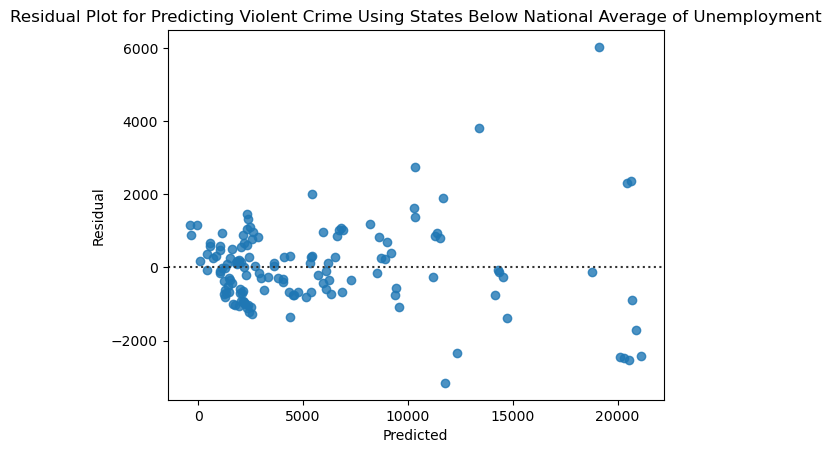

In [118]:
ax = sns.residplot(data= y_below_df, x = 'Preds', y = 'Actual')
ax.set(xlabel = "Predicted", ylabel= "Residual", title="Residual Plot for Predicting Violent Crime Using States Below National Average of Unemployment");

Clearly, this residual plot is very hetereoskedastic, calling for a log transformation.

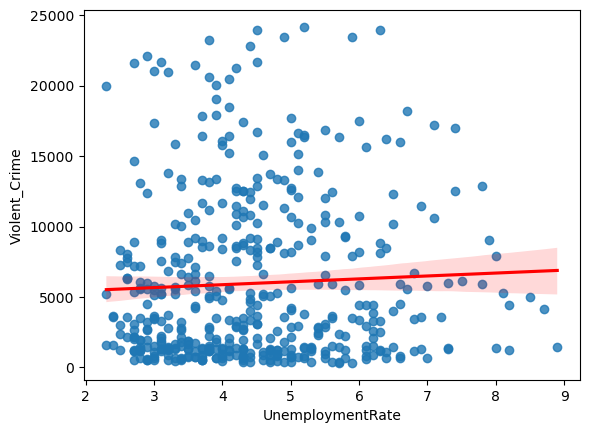

In [119]:
sns.regplot(x = states_below_df['UnemploymentRate'], y = states_below_df['Violent_Crime'], line_kws = {"color":"red"});

Moreover, looking at this linear regression plot, we can observe that there needs to be a log transformation on the y axis (violent crime rates). This is because if we look at the axes, the y axis is increasing at a much greater rate than the x axis is increasing. Moreover, in the plot itself, we can observe that there are many data points that are outliers in terms of y axis, comparative to our linear regression line. 

MAE for predicting violent crime rate using states below national average: 0.22514088308826197
RSME for predicting violent crime rate using states below national average: 0.29602961420061813


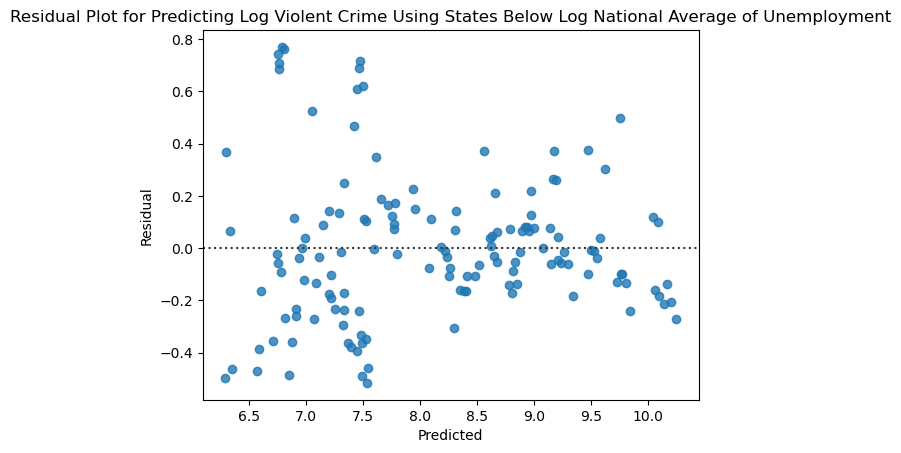

In [120]:
states_below_df['log_crime'] = np.log(states_below_df['Violent_Crime'])

X_train_below, X_test_below, Y_train_below, Y_test_below = \
  train_test_split(states_below_df.iloc[:,1:-1],
                   states_below_df['log_crime'], test_size=.30, shuffle=False)
#print(Y_test)
X_train_below = sm.add_constant(X_train_below)
model_below = sm.OLS( Y_train_below,X_train_below).fit()

X_test_below = sm.add_constant(X_test_below)
preds_below = model_below.predict(X_test_below)
y_below_df = pd.DataFrame(data = {"Preds":preds_below, "Actual":Y_test_below})
y_below_df.head()

print( f"MAE for predicting violent crime rate using states below national average: {mean_absolute_error(preds_below,Y_test_below)}")
print( f"RSME for predicting violent crime rate using states below national average: {root_mean_squared_error(preds_below,Y_test_below)}")

ax = sns.residplot(data= y_below_df, x = 'Preds', y = 'Actual')
ax.set(xlabel = "Predicted", ylabel= "Residual",
       title="Residual Plot for Predicting Log Violent Crime Using States Below Log National Average of Unemployment");


After doing the log transformation on the y axis, we can observe that this residual plot is much more random. It is no longer exemplifying the heteroskedastic, fan shape from the previous residual plot. Moreover, we can also see that the MAE and RMSE have decreased substantially from our previous model (without the log transformation), which demonstrates that this model is much more accurate and reliable.

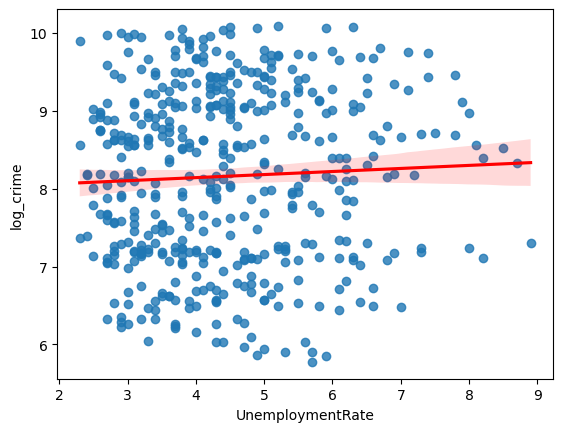

In [121]:
sns.regplot(x = states_below_df['UnemploymentRate'], y = states_below_df['log_crime'], line_kws = {"color":"red"});

In [122]:
print(model_below.summary())

                            OLS Regression Results                            
Dep. Variable:              log_crime   R-squared:                       0.970
Model:                            OLS   Adj. R-squared:                  0.969
Method:                 Least Squares   F-statistic:                     781.0
Date:                Thu, 21 Nov 2024   Prob (F-statistic):          1.10e-229
Time:                        19:50:52   Log-Likelihood:                 63.834
No. Observations:                 327   AIC:                            -99.67
Df Residuals:                     313   BIC:                            -46.61
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const              -18.2185      2.408  

Looking at this OLS regression, we observe that the p value for unemployment rate is significant (based on a 0.05 significance level). Moreover, we observe that the p value for the year is insignificant since it is greater than the 0.05 signficance level. This shows that the significant coefficient for unemployment rate, which is -0.0450. This shows that for every one unit increase in the unemployment rate, that corresponds to a e^(-0.045) increase in the amount of violent crime rate. Due to the p value being lower than the signfiicance level, we can reject the null hypothesis (that there is no relationship between unemployment rates among states lower than the national average and violent crime rates). There is a relationship that exists.

## Conclusion

In conclusion, when looking at the average unemployment rate over the years vs average violent crime rates over the years, we got a significant coefficient, showing a positive relationship between the two. This allowed us to reject the null hypothesis (that there was no relationship between average unemployment rate over the years vs average violent crime rates over the years), as we observed a significant p value. From there, to actually test our specific hypothesis, we looked at two groups: states that have an unemployment rate that is lower than the national average and states that have an unemployment rate that is greater than the national average. With this information, we created two models that can predict the violent crime rates based on the category of unemployment rate the states fall into (either below or above the national average).

After log transformations, we observed the following about our predictive models:
#### States Below National Average:
- RMSE: 0.29602961420061813
- MAE: 0.22514088308826197

#### States Above National Average:

- RSME: 0.2720943011106594
- MAE: 0.21877660270929272

With the relatively low and similar RMSE and MAE values across the states that are above and below the national average, we can conclude that both of our models are quite accurate.

Moreover, with OLS regression models for both of the two groups, we also performed signficance testing showing that for states that are below the national average, the coefficient for unemployment rate vs violent crime rates was significant, and for states that are above the national average, the coefficient for unemployment rate vs violent crime rates was also signficant. So, for both of these groups, we should reject the null hypothesis (that there is no relationship between unemployment rate and violent crime rates). There is a relationship for both models (above and below the national average) between unemployment rate and violent crime rates.

# Hypothesis 3
### At least one of income, population, unemployment, and poverty (+ year) have a relationship with the 4 categories of violent crime for each state regardless of the year.



In [123]:
crime_job = duckdb.sql('''SELECT C.State, C.Year, UnemploymentRate,
                               C.Population,
                               FROM crime_df AS C
                               JOIN job_melt AS J ON
                               C.Year = J.Year AND J.Area = C.State
                               ''').df()
cj_poverty = duckdb.sql('''SELECT C.State, C.Year, C.Population, UnemploymentRate, PovertyPercent
                               FROM crime_job AS C
                               JOIN poverty_concat AS P ON
                               C.Year = P.Year AND C.State = P.State
                               ''').df()
four_factors= duckdb.sql('''SELECT C.State, C.Year, C.Population, UnemploymentRate, PovertyPercent,
                        Median_Income
                               FROM cj_poverty AS C
                               JOIN income_melt AS I ON
                               C.Year = I.Year AND C.State = I.State
                               ORDER BY C.Year ASC''').df()
four_factors.head() #2013 - 2018

,State,Year,Population,UnemploymentRate,PovertyPercent,Median_Income
0,Alabama,2013,4833996,7.2,16.7,47320.0
1,Alaska,2013,737259,7.0,10.9,72472.0
2,Arizona,2013,6634997,7.7,20.2,52611.0
3,Arkansas,2013,2958765,7.2,17.1,39376.0
4,California,2013,38431393,8.9,14.9,60794.0


## 3.1 Hypothesis
At least one of income, population, unemployment, and poverty (+ year) have a relationship with rape of each state regardless of the year.

### MODEL FOR RAPE

In [124]:
rape_fourfactors= duckdb.sql('''SELECT C.Rape, F.*
                               FROM crime_df AS C
                               JOIN four_factors AS F ON
                               C.Year = F.Year AND C.State = F.State
                               ORDER BY C.Year ASC''').df()
rape_fourfactors = pd.get_dummies(rape_fourfactors, prefix='', prefix_sep='',\
                                  drop_first=True, dtype=int, columns=['State'])
#print(rape_fourfactors)
X4_train_rape, X4_test_rape, Y4_train_rape, Y4_test_rape = \
  train_test_split(rape_fourfactors.iloc[:,1:], rape_fourfactors['Rape'],\
                   test_size=.30, shuffle=False)
X4_train_rape = sm.add_constant(X4_train_rape)
model_rape = sm.OLS(Y4_train_rape,X4_train_rape).fit()
print(model_rape.summary())

                            OLS Regression Results                            
Dep. Variable:                   Rape   R-squared:                       0.991
Model:                            OLS   Adj. R-squared:                  0.988
Method:                 Least Squares   F-statistic:                     372.1
Date:                Thu, 21 Nov 2024   Prob (F-statistic):          3.06e-167
Time:                        19:50:53   Log-Likelihood:                -1693.3
No. Observations:                 245   AIC:                             3497.
Df Residuals:                     190   BIC:                             3689.
Df Model:                          54                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             4.335e+04    6.7e+04  

If we look exclusively at the four factors (+ year): Year, Population, Unemployment Rate, Poverty Percent, and Median Income, we can see that there is significant coefficient (based on a 0.05 signficance level) for population. Thus, we can reject the null hypothesis that none of the four factors (+ year) have a significant relationship with rape.

In [125]:
#make predictions using rape model
X4_test_rape = sm.add_constant(X4_test_rape)
rape4_preds = model_rape.predict(X4_test_rape)
print( f"MAE for predicting rape using the four factors: {mean_absolute_error(Y4_test_rape, rape4_preds)}")
print( f"RSME for predicting rape using the four factors: {root_mean_squared_error(Y4_test_rape, rape4_preds)}")

MAE for predicting rape using the four factors: 311.51113832282806
RSME for predicting rape using the four factors: 513.7375185739035


## 3.2 Hypothesis
At least one of income, population, unemployment, and poverty (+ year) have a relationship with homicide of each state regardless of the year.

### MODEL FOR HOMICIDE

In [126]:
homicide_fourfactors= duckdb.sql('''SELECT C.Homicide, F.*
                               FROM crime_df AS C
                               JOIN four_factors AS F ON
                               C.Year = F.Year AND C.State = F.State
                               ORDER BY C.Year ASC''').df()
homicide_fourfactors = pd.get_dummies(homicide_fourfactors, prefix='', prefix_sep='',\
                                  drop_first=True, dtype=int, columns=['State'])
#print(homicide_fourfactors)

X4_train_homi, X4_test_homi, Y4_train_homi, Y4_test_homi = \
  train_test_split(homicide_fourfactors.iloc[:,1:], homicide_fourfactors['Homicide'],\
                   test_size=.30, shuffle=False)
X4_train_homi = sm.add_constant(X4_train_homi)
model_homicide = sm.OLS(Y4_train_homi,X4_train_homi).fit()
print(model_homicide.summary())

                            OLS Regression Results                            
Dep. Variable:               Homicide   R-squared:                       0.991
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                     402.7
Date:                Thu, 21 Nov 2024   Prob (F-statistic):          1.84e-170
Time:                        19:50:54   Log-Likelihood:                -1201.4
No. Observations:                 245   AIC:                             2513.
Df Residuals:                     190   BIC:                             2705.
Df Model:                          54                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const            -2.392e+04   8998.286  

If we look exclusively at the four factors (+ year): Year, Population, Unemployment Rate, Poverty Percent, and Median Income, we can see that there are significant coefficients (based on a 0.05 signficance level) for year and population. Thus, we can reject the null hypothesis that none of the four factors (+ year) have a significant relationship with homicide.

In [127]:
#make predictions using homicide model
X4_test_homi = sm.add_constant(X4_test_homi)
homicide4_preds = model_homicide.predict(X4_test_homi)
print( f"MAE for predicting homicide using the four factors: {mean_absolute_error( Y4_test_homi,homicide4_preds)}")
print( f"RSME for predicting homicide using the four factors: {root_mean_squared_error(Y4_test_homi, homicide4_preds)}")

MAE for predicting homicide using the four factors: 56.87366284538613
RSME for predicting homicide using the four factors: 71.35952924641684


## 3.3 Hypothesis
At least one of income, population, unemployment, and poverty (+ year) have a relationship with aggravated assault of each state regardless of the year.

### MODEL FOR AGGRAVATED ASSAULT

In [128]:
assault_fourfactors= duckdb.sql('''SELECT C.Aggravated_Assault, F.*
                               FROM crime_df AS C
                               JOIN four_factors AS F ON
                               C.Year = F.Year AND C.State = F.State
                               ORDER BY C.Year ASC''').df()
assault_fourfactors = pd.get_dummies(assault_fourfactors, prefix='', prefix_sep='',\
                                  drop_first=True, dtype=int, columns=['State'])
#print(assault_fourfactors)

X4_train_assault, X4_test_assault, Y4_train_assault, Y4_test_assault = \
  train_test_split(assault_fourfactors.iloc[:,1:], assault_fourfactors['Aggravated_Assault'],\
                   test_size=.30, shuffle=False)
X4_train_assault = sm.add_constant(X4_train_assault)
model_assault = sm.OLS(Y4_train_assault,X4_train_assault).fit()
print(model_assault.summary())

                            OLS Regression Results                            
Dep. Variable:     Aggravated_Assault   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                     1345.
Date:                Thu, 21 Nov 2024   Prob (F-statistic):          6.70e-220
Time:                        19:50:54   Log-Likelihood:                -2022.1
No. Observations:                 245   AIC:                             4154.
Df Residuals:                     190   BIC:                             4347.
Df Model:                          54                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const            -1.722e+05   2.56e+05  

If we look exclusively at the four factors (+ year): Year, Population, Unemployment Rate, Poverty Percent, and Median Income, we can see that there is significant coefficient (based on a 0.05 signficance level) for population. Thus, we can reject the null hypothesis that none of the four factors (+ year) have a significant relationship with aggravated assault.

In [129]:
#make predictions using assault model
X4_test_assault = sm.add_constant(X4_test_assault)
assault4_preds = model_assault.predict(X4_test_assault)
print( f"MAE for predicting aggravated assault using the four factors: {mean_absolute_error( Y4_test_assault,assault4_preds)}")
print( f"RSME for predicting aggravated assault using the four factors: {root_mean_squared_error(Y4_test_assault,assault4_preds)}")

MAE for predicting aggravated assault using the four factors: 1381.499564508074
RSME for predicting aggravated assault using the four factors: 2261.354298039466


## 3.4 Hypothesis
At least one of income, population, unemployment, and poverty (+ year) have a relationship with robbery of each state regardless of the year.

### MODEL FOR ROBBERY

In [130]:
robbery_fourfactors= duckdb.sql('''SELECT C.Robbery, F.*
                               FROM crime_df AS C
                               JOIN four_factors AS F ON
                               C.Year = F.Year AND C.State = F.State
                               ORDER BY C.Year ASC''').df()
robbery_fourfactors = pd.get_dummies(robbery_fourfactors , prefix='', prefix_sep='',\
                                  drop_first=True, dtype=int, columns=['State'])
#print(robbery_fourfactors)

X4_train_robbery, X4_test_robbery, Y4_train_robbery, Y4_test_robbery = \
  train_test_split(robbery_fourfactors .iloc[:,1:], robbery_fourfactors ['Robbery'],\
                   test_size=.30, shuffle=False)
X4_train_robbery = sm.add_constant(X4_train_robbery)
model_robbery = sm.OLS(Y4_train_robbery,X4_train_robbery).fit()
print(model_robbery.summary())

                            OLS Regression Results                            
Dep. Variable:                Robbery   R-squared:                       0.996
Model:                            OLS   Adj. R-squared:                  0.995
Method:                 Least Squares   F-statistic:                     946.8
Date:                Thu, 21 Nov 2024   Prob (F-statistic):          1.79e-205
Time:                        19:50:55   Log-Likelihood:                -1904.5
No. Observations:                 245   AIC:                             3919.
Df Residuals:                     190   BIC:                             4112.
Df Model:                          54                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const            -2.958e+05   1.59e+05  

If we look exclusively at the four factors (+ year): Year, Population, Unemployment Rate, Poverty Percent, and Median Income, we can see that there are significant coefficients (based on a 0.05 signficance level) for unemployment rate and population. Thus, we can reject the null hypothesis that none of the four factors (+ year) have a significant relationship with robbery.

In [131]:
#make predictions using robbery model
X4_test_robbery = sm.add_constant(X4_test_robbery)
robbery4_preds = model_robbery.predict(X4_test_robbery)
print( f"MAE for predicting robbery using the four factors: {mean_absolute_error( Y4_test_robbery,robbery4_preds)}")
print( f"RSME for predicting robbery using the four factors: {root_mean_squared_error(Y4_test_robbery,robbery4_preds)}")

MAE for predicting robbery using the four factors: 922.7968418143154
RSME for predicting robbery using the four factors: 1557.551744183678
